In [1]:
# All imports


from prettyprinter import pprint 

import numpy as np
import pandas as pd
import json


import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]
import seaborn as sns
sns.set_style('dark')

import tensorly as tl
from tensorly.decomposition import parafac,tucker

import scipy,sklearn
import  sklearn.decomposition

import time

In [2]:
# import data
# Unzip if not already done
import os,shutil
if not 'mumbai-hexclusters-2019-4-All-HourlyAggregate.csv' in os.listdir('../data/'):
    shutil.unpack_archive(filename="../mumbai-hexclusters-2019-4-All-HourlyAggregate.zip",extract_dir='../data/')

In [3]:
df = pd.read_csv('../data/mumbai-hexclusters-2019-4-All-HourlyAggregate.csv')

In [4]:
df.head()

,sourceid,dstid,hod,mean_travel_time,standard_deviation_travel_time,geometric_mean_travel_time,geometric_standard_deviation_travel_time
0,171,206,15,2949.31,1139.79,2772.51,1.40
1,255,439,10,5045.33,839.06,4978.27,1.18
2,110,18,0,2932.71,537.47,2886.25,1.19
3,38,7,5,2690.29,741.75,2591.41,1.31
4,277,219,10,4848.73,730.67,4796.48,1.16


In [5]:
origins = sorted(df.sourceid.unique())
destinations = sorted(df.dstid.unique())
hods = sorted(df.hod.unique())

origin_max = max(origins)
dest_max = max(destinations)
hod_max = max(hods)

list(map(min,[origins,destinations,hods]))

# Make numpy tensor
nptensor = np.zeros(     (   dest_max, origin_max, hod_max+1  )      ) 
        
def transfer(x):
    nptensor[x.dstid-1 ,x.sourceid-1, x.hod] = x.mean_travel_time
    return 0

df.pipe(transfer)

0

In [6]:
print(nptensor[300,3,10])
# verify if nptensor has right data
df[df.sourceid==4] [ df.dstid==301 ] [ df.hod==10]

1718.02


/home/sampad/pyv/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/sampad/pyv/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


,sourceid,dstid,hod,mean_travel_time,standard_deviation_travel_time,geometric_mean_travel_time,geometric_standard_deviation_travel_time
1261503,4,301,10,1718.02,619.9,1633.91,1.35


In [7]:
# create tensorly data
#nptensor -= nptensor.mean()
tensor = tl.tensor(nptensor)

In [8]:
# parafac with ortogonality
def tensorrank2variance(k, algo):
    _verbose=0
    _iters = 100
    now = time.time()
    if algo=='parafac':
        _factors,_errors = parafac(tensor, rank=k, return_errors=True, orthogonalise=False, n_iter_max = _iters, verbose=_verbose,linesearch=True)
        _weights, _components = _factors
        _params = sum(tensor.shape)*k
        reconstruction_error = tl.norm(tensor - tl.cp_to_tensor((_weights, _components)))
       
        #print(_weights)
    
    elif algo=='parafacortho':
        _factors,_errors = parafac(tensor, rank=k, return_errors=True, orthogonalise=True, n_iter_max=_iters, verbose=_verbose)
        _weights, _components = _factors
        _params = sum(tensor.shape)*k
        reconstruction_error = tl.norm(tensor - tl.cp_to_tensor((_weights, _components)))
        #print(_weights)
        
        
        
    elif algo=='tucker':
        _core, _factors, =  tucker(tensor, rank=k, verbose = 1)
        _params = sum(tensor.shape)*k + k**3
        reconstruction_error = tl.norm(  tensor - tl.tucker_to_tensor((_core, _factors))  )
        

    
    #print(reconstruction_error / tl.norm(tensor))
    #print(errors)

    # total_var = norm**2 = explained_var + error**2
    # => total_var = explained_var + error**2
    # => explained_var = total_var - error**2
    # => explained_var_normalized = explained_var / total_var

    total_variance = tl.norm(tensor)**2
    explained_variance = total_variance - reconstruction_error**2
    explained_variance_normalized = explained_variance / total_variance
    
    print()
    print(f'error -> {reconstruction_error}')
    print(f'{algo} - rank-{k} explained->',explained_variance_normalized)
    took = time.time() - now
    print(f'{algo} - rank-{k} took->',took)
    print()
    return explained_variance_normalized,took,_params


In [9]:
explained_parafac = [tensorrank2variance(k, 'parafac') for k in range(1,21)]


error -> 4761583.105480774
parafac - rank-1 explained-> 0.6642287371449557
parafac - rank-1 took-> 1.0104587078094482


error -> 4356951.96293708
parafac - rank-2 explained-> 0.7188705582169544
parafac - rank-2 took-> 22.59603977203369


error -> 4045296.743906231
parafac - rank-3 explained-> 0.7576508188404651
parafac - rank-3 took-> 31.169645071029663


error -> 3845668.3072755234
parafac - rank-4 explained-> 0.7809796678586474
parafac - rank-4 took-> 39.22890830039978


error -> 3655403.6023579757
parafac - rank-5 explained-> 0.8021156458299986
parafac - rank-5 took-> 47.28205323219299


error -> 3545822.258866905
parafac - rank-6 explained-> 0.8138021290546626
parafac - rank-6 took-> 55.01208233833313


error -> 3468230.754457755
parafac - rank-7 explained-> 0.8218619241953863
parafac - rank-7 took-> 63.007620096206665


error -> 3398276.2843762506
parafac - rank-8 explained-> 0.8289755681995035
parafac - rank-8 took-> 70.44271302223206


error -> 3327274.648971788
parafac - rank-

In [10]:
explained_parafacortho = [tensorrank2variance(k, 'parafacortho') for k in range(1,21)]


error -> 4761583.105480774
parafacortho - rank-1 explained-> 0.6642287371449557
parafacortho - rank-1 took-> 1.0178711414337158


error -> 4359413.4189517535
parafacortho - rank-2 explained-> 0.7185528208490924
parafacortho - rank-2 took-> 16.32642698287964


error -> 4046679.7941766637
parafacortho - rank-3 explained-> 0.7574850765380068
parafacortho - rank-3 took-> 24.177043914794922


error -> 3848279.4769198876
parafacortho - rank-4 explained-> 0.7806821417310889
parafacortho - rank-4 took-> 31.844497442245483


error -> 3658158.2781122546
parafacortho - rank-5 explained-> 0.8018172860943334
parafacortho - rank-5 took-> 39.80767273902893


error -> 3547598.4154921235
parafacortho - rank-6 explained-> 0.8136155436093532
parafacortho - rank-6 took-> 47.56210374832153


error -> 3466504.3862326057
parafacortho - rank-7 explained-> 0.8220392223027047
parafacortho - rank-7 took-> 55.17572593688965


error -> 3398020.7769391336
parafacortho - rank-8 explained-> 0.8290012849852076
parafa

In [11]:
explained_tucker = [tensorrank2variance(k, 'tucker') for k in range(1,21)]

/home/sampad/pyv/lib/python3.6/site-packages/tensorly/tucker_tensor.py:357: RuntimeWarning: Given only one int for 'rank' for decomposition a tensor of order 3. Using this rank for all modes.
  warnings.warn(message, RuntimeWarning)


reconstruction error=0.5794577318570726, variation=1.8247150457284533e-08.
converged in 2 iterations.

error -> 4761583.106572
tucker - rank-1 explained-> 0.6642287369910563
tucker - rank-1 took-> 1.0159189701080322

reconstruction error=0.529933432638772, variation=1.528799186989449e-05.
converged in 2 iterations.

error -> 4354626.64787237
tucker - rank-2 explained-> 0.7191705569716869
tucker - rank-2 took-> 1.0656523704528809

reconstruction error=0.4898298971107695, variation=2.4548232173682294e-06.
converged in 2 iterations.

error -> 4025083.513342157
tucker - rank-3 explained-> 0.760066671896452
tucker - rank-3 took-> 1.1197736263275146

reconstruction error=0.46622817406766304, variation=5.078463242380593e-05.
converged in 2 iterations.

error -> 3831140.86739993
tucker - rank-4 explained-> 0.7826312897055311
tucker - rank-4 took-> 1.106661081314087

reconstruction error=0.44166983759294526, variation=8.794273540502218e-07.
converged in 2 iterations.

error -> 3629337.433508798

In [12]:
# Lets now build the matrix with shape  (nodes ^ 2) x  t 
print(nptensor.shape)
npmatrix =  np.zeros((nptensor.shape[0] * nptensor.shape[1],nptensor.shape[2]))
print(npmatrix.shape)

for x in range(npmatrix.shape[1]):
    npmatrix[:,x] = nptensor[:,:,x].flatten()
    
    

### SVD for this matrix

def matrixrank2variance(k):
    now = time.time()
    _svd = sklearn.decomposition.TruncatedSVD(n_components=k, n_iter=100, random_state=42)
    _svd.fit(npmatrix)
    _nparams = sum(npmatrix.shape)*k + k
    #print(svd.explained_variance_ratio_)
    took = time.time() - now
    print()
    print(f'SVD-rank-{k} explains->',_svd.explained_variance_ratio_.sum())
    print(f'SVD-rank-{k} took->',took)
    print()
    return _svd.explained_variance_ratio_.sum(), took, _nparams
    
    

(695, 695, 24)
(483025, 24)


In [13]:
explained_svd = [matrixrank2variance(k) for k in range(1,21)]


SVD-rank-1 explains-> 0.8007682250150465
SVD-rank-1 took-> 25.710879802703857


SVD-rank-2 explains-> 0.8399175718190733
SVD-rank-2 took-> 28.071985721588135


SVD-rank-3 explains-> 0.8732156209306671
SVD-rank-3 took-> 28.85221266746521


SVD-rank-4 explains-> 0.8868811529129729
SVD-rank-4 took-> 29.409460067749023


SVD-rank-5 explains-> 0.8981679056843995
SVD-rank-5 took-> 29.577184200286865


SVD-rank-6 explains-> 0.9070683748033164
SVD-rank-6 took-> 36.19971799850464


SVD-rank-7 explains-> 0.9154527955817334
SVD-rank-7 took-> 39.57246208190918


SVD-rank-8 explains-> 0.9231756907216467
SVD-rank-8 took-> 41.718570947647095


SVD-rank-9 explains-> 0.9304854674460094
SVD-rank-9 took-> 42.959800004959106


SVD-rank-10 explains-> 0.936896816788064
SVD-rank-10 took-> 44.12616300582886


SVD-rank-11 explains-> 0.9429270546727646
SVD-rank-11 took-> 45.07195568084717


SVD-rank-12 explains-> 0.9486673526439514
SVD-rank-12 took-> 46.838125705718994


SVD-rank-13 explains-> 0.95408643506279

In [16]:
import dill
#dill.dump_session('var2rank.pickle')
dill.load_session('var2rank.pickle')

TypeError: can't pickle BackendAttributeModuleType objects

In [17]:
var_cp = map(lambda x:x[0], explained_parafac)
var_cportho = map(lambda x:x[0], explained_parafacortho)
var_tucker = map(lambda x:x[0], explained_tucker)
var_svd = map(lambda x:x[0], explained_svd)

took_cp = map(lambda x:x[1], explained_parafac)
took_cportho = map(lambda x:x[1], explained_parafacortho)
took_tucker = map(lambda x:x[1], explained_tucker)
took_svd = map(lambda x:x[1], explained_svd)

nparams_cp = map(lambda x:x[2], explained_parafac)
nparams_cportho = map(lambda x:x[2], explained_parafacortho)
nparams_tucker = map(lambda x:x[2], explained_tucker)
nparams_svd = map(lambda x:x[2], explained_svd)

In [18]:
rank2var = pd.DataFrame(      {'cp': var_cp  , 'cportho': var_cportho, 'tucker': var_tucker , 'svd': var_svd}                 )
rank2var.index = range(1,21)

rank2took = pd.DataFrame(     {'cp': took_cp , 'cportho': took_cportho , 'tucker': took_tucker, 'svd': took_svd  }             )
rank2took.index = range(1,21)

rank2nparams = pd.DataFrame(   {'cp': nparams_cp  , 'cportho': nparams_cportho , 'tucker': nparams_tucker, 'svd': nparams_svd  }   )
rank2nparams.index = range(1,21)

[Text(0.5, 0, 'rank'), Text(0, 0.5, 'explained_variance')]

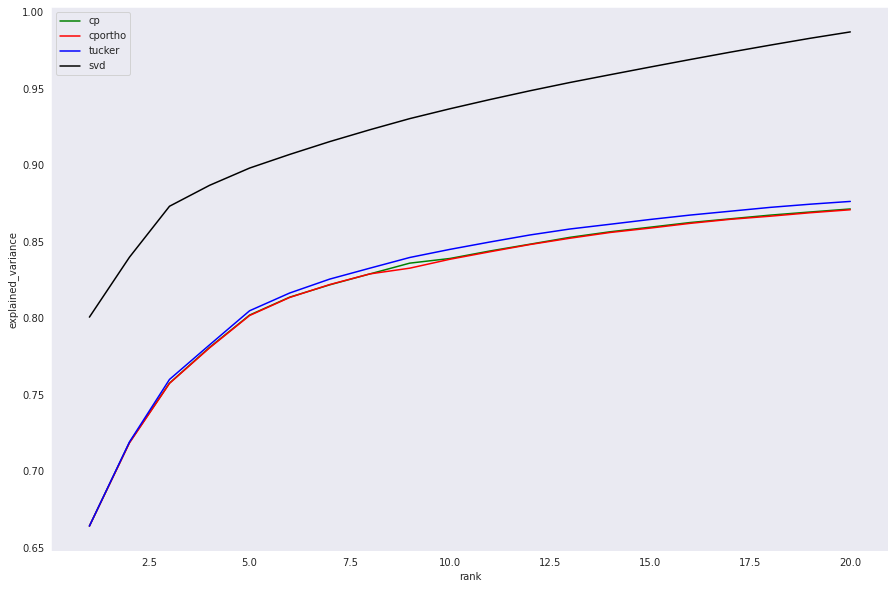

In [19]:
sns.lineplot( data = rank2var.cp, color='g', label='cp' )
sns.lineplot( data = rank2var.cportho, color='r', label='cportho')
sns.lineplot( data = rank2var.tucker, color='b', label='tucker')
ax = sns.lineplot( data = rank2var.svd, color='black', label='svd')
ax.set(xlabel='rank', ylabel='explained_variance')

[Text(0.5, 0, 'rank'), Text(0, 0.5, 'compute_time [seconds]')]

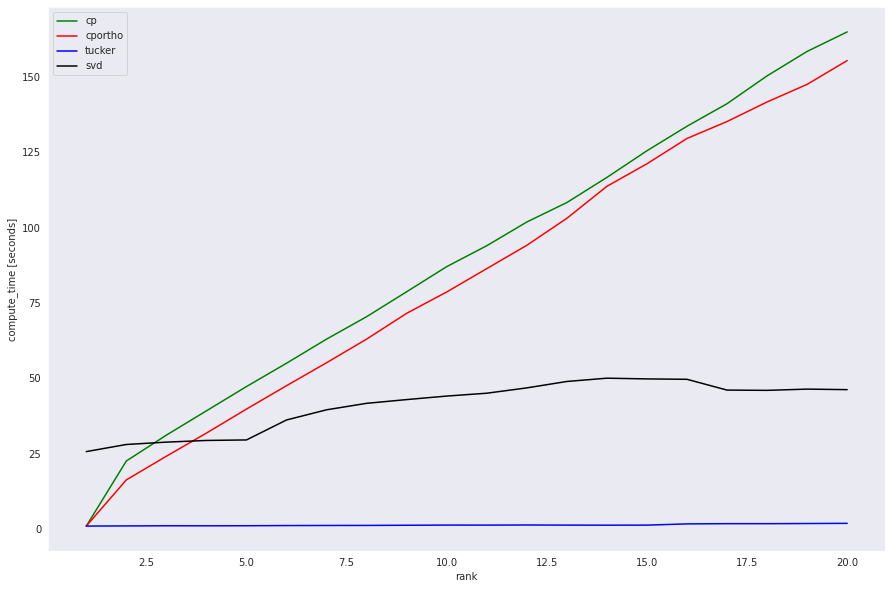

In [20]:
sns.lineplot( data = rank2took.cp, color='g', label='cp')
sns.lineplot( data = rank2took.cportho, color='r', label='cportho')
sns.lineplot( data = rank2took.tucker, color='b', label='tucker')
ax = sns.lineplot( data = rank2took.svd, color='black', label='svd')
ax.set(xlabel='rank', ylabel='compute_time [seconds]')

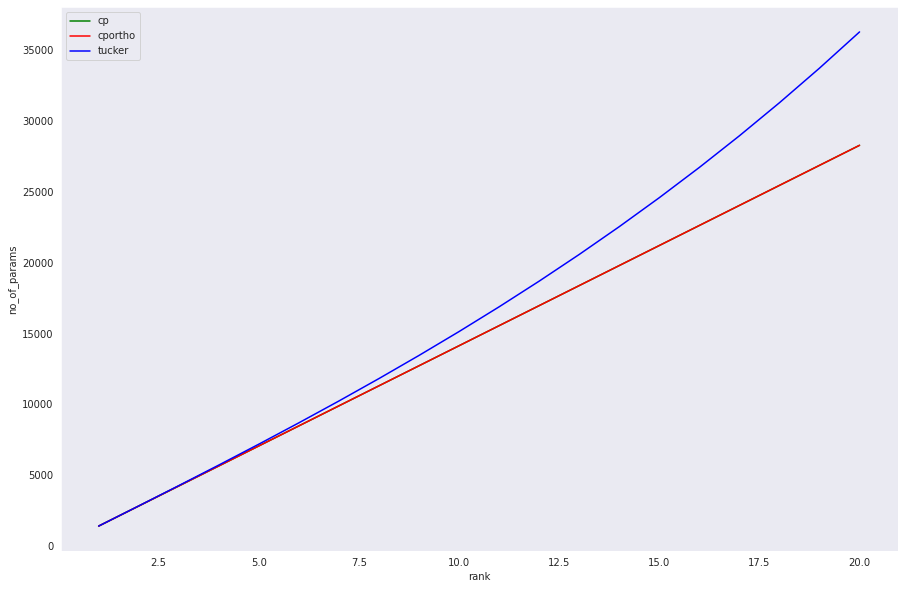

In [21]:
sns.lineplot( data = rank2nparams.cp, color='g', label='cp')
sns.lineplot( data = rank2nparams.cportho, color='r', label='cportho')
ax = sns.lineplot( data = rank2nparams.tucker, color='b', label='tucker')
#ax = sns.lineplot( data = rank2nparams.svd, color='black', label='svd')
ax.set(xlabel='rank',ylabel='no_of_params')
ax.legend()

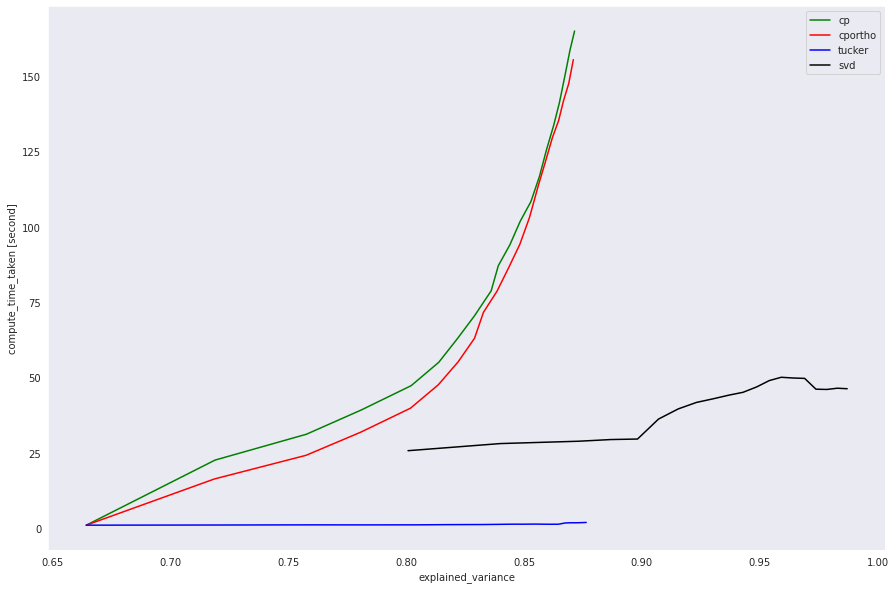

In [22]:
plt.plot(rank2var.cp, rank2took.cp, label='cp', c='g')
plt.plot(rank2var.cportho, rank2took.cportho, label='cportho', c='r')
plt.plot(rank2var.tucker, rank2took.tucker, label='tucker', c='b')
plt.plot(rank2var.svd, rank2took.svd, label='svd', c='black')
plt.xlabel('explained_variance')
plt.ylabel('compute_time_taken [second]')
plt.legend()

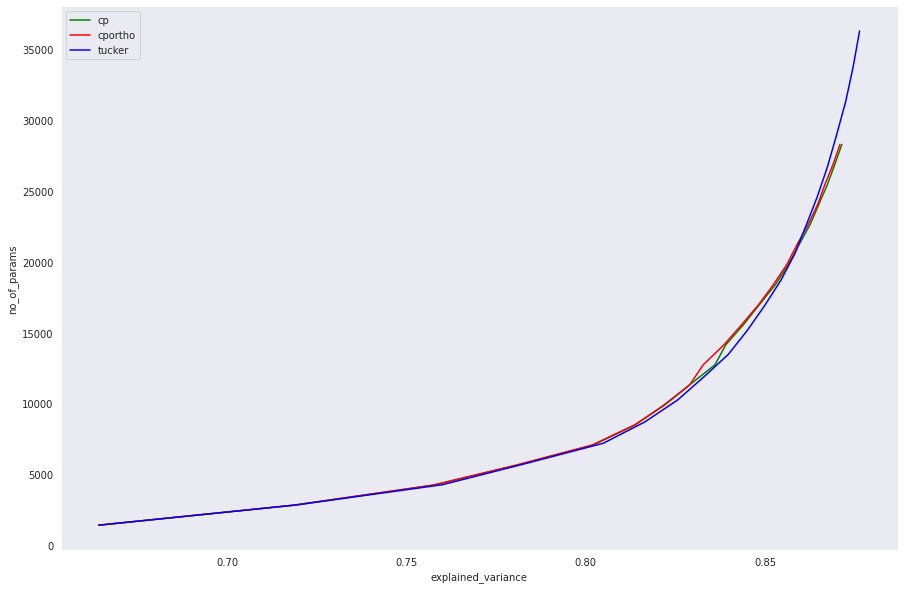

In [23]:
plt.plot(rank2var.cp, rank2nparams.cp, label='cp', c='g')
plt.plot(rank2var.cportho, rank2nparams.cportho, label='cportho', c='r')
plt.plot(rank2var.tucker, rank2nparams.tucker, label='tucker', c='b')
#plt.plot(rank2var.svd, rank2nparams.svd, label='svd', c='black')
plt.xlabel('explained_variance')
plt.ylabel('no_of_params')
plt.legend()

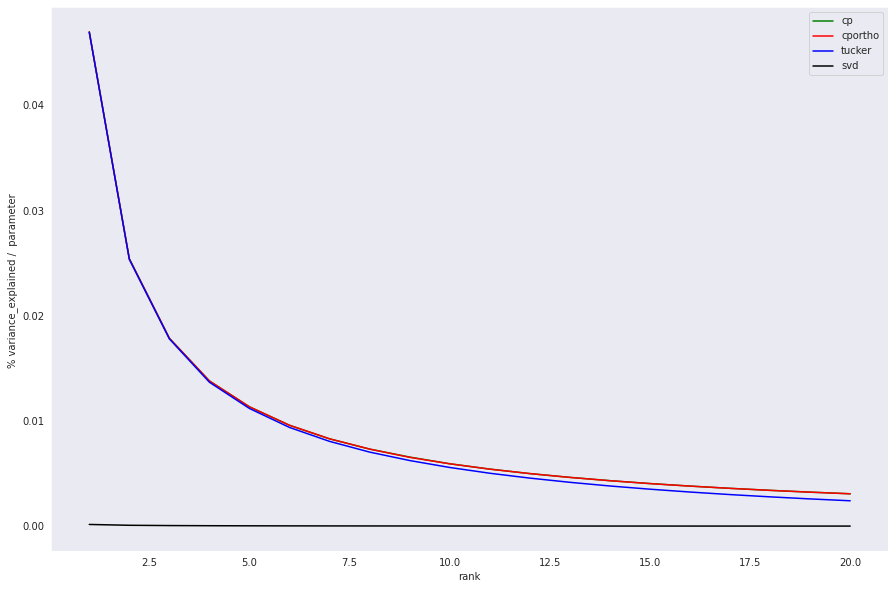

In [24]:
plt.plot(rank2var.cp *100 / rank2nparams.cp, label='cp', c='g')
plt.plot(rank2var.cportho *100/ rank2nparams.cportho, label='cportho', c='r')
plt.plot(rank2var.tucker *100/ rank2nparams.tucker, label='tucker', c='b')
plt.plot(rank2var.svd *100/ rank2nparams.svd, label='svd', c='black')
plt.xlabel('rank')
plt.ylabel('% variance_explained /  parameter ')
plt.legend()

In [25]:
np.array([1,2,3]) / np.array([1,2,6])

array([1. , 1. , 0.5])

In [26]:
rank2nparams.svd / rank2nparams.cp

1     341.619519
2     341.619519
3     341.619519
4     341.619519
5     341.619519
6     341.619519
7     341.619519
8     341.619519
9     341.619519
10    341.619519
11    341.619519
12    341.619519
13    341.619519
14    341.619519
15    341.619519
16    341.619519
17    341.619519
18    341.619519
19    341.619519
20    341.619519
dtype: float64

In [27]:
rank2nparams.svd / rank2nparams.tucker

1     341.378092
2     340.655853
3     339.458890
4     337.797203
5     335.684503
6     333.137931
7     330.177717
8     326.826793
9     323.110368
10    319.055482
11    314.690554
12    310.044929
13    305.148452
14    300.031056
15    294.722392
16    289.251497
17    283.646506
18    277.934407
19    272.140845
20    266.289967
dtype: float64

In [28]:
### MORE RANK

In [29]:
explained_parafac2150 = [tensorrank2variance(k, 'parafac') for k in range(21,50)]

KeyboardInterrupt: 

In [ ]:
explained_tucker2150 = [tensorrank2variance(k, 'tucker') for k in range(21,50)]

In [ ]:
### MASK